<a href="https://colab.research.google.com/github/adildhkh/deep-learning/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install protobuf==3.20.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [1]:
!git clone https://github.com/tensorflow/models.git
!cd models/research && protoc object_detection/protos/*.proto --python_out=.


fatal: destination path 'models' already exists and is not an empty directory.


In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'models/research'))
sys.path.append(os.path.join(os.getcwd(), 'models/research/slim'))


In [3]:
!pip install -U pip
!pip install tensorflow
!pip install tensorflow-addons
!pip install Cython
!pip install contextlib2
!pip install pillow
!pip install lxml
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install tf-slim
!pip install pycocotools


In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils


2024-12-01 06:20:45.716217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 06:20:45.847566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 06:20:45.880069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 06:20:45.961813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 06:20:50.208254: W tensorflow/compiler/tf2

In [5]:
# Clone TensorFlow Models repository
!git clone http://github.com/tensorflow/models.git

# Install protobuf compiler and compile the proto files
!cd models/research && protoc object_detection/protos/*.proto --python_out=.

# Install Object Detection API
!cp object_detection/packages/tf2/setup.py . && python -m pip install .

# Necessary Imports
import os
import pathlib
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


fatal: destination path 'models' already exists and is not an empty directory.
cp: cannot stat 'object_detection/packages/tf2/setup.py': No such file or directory


In [6]:
# Placeholder for loading images from Google Drive
# Replace with code to load your images from Google Drive if needed
IMAGE_PATHS = ['intersection.jpeg', 'traffic.jpeg']

# Download the model
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'
PATH_TO_MODEL_DIR = tf.keras.utils.get_file(
    fname='ssd_resnet101_v1_fpn_640x640_coco17_tpu-8', origin=model_url, untar=True)

# Download the label map
label_map_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'
PATH_TO_LABELS = tf.keras.utils.get_file(fname='mscoco_label_map.pbtxt', origin=label_map_url, untar=False)

!head {PATH_TO_LABELS}  # Print the first few lines of the label map to check class IDs and names



386527459/386527459 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
5056/5056 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


In [7]:
# Load the TensorFlow model
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
print('Loading model...', end=' ')
start_time = time.time()
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Took {elapsed_time:.2f} seconds')

# Load the label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)



Loading model... Done! Took 27.16 seconds


In [8]:
# Helper function to load an image into a numpy array
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

# Object detection function
def detect_objects(image_path):
    print(f'Running inference for {image_path}...', end=' ')
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    unique_classes = set(detections['detection_classes'])
    print('Classes found:')
    for c in unique_classes:
        print(category_index[c]['name'])

    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.30,
        agnostic_mode=False)

    plt.figure(figsize=(15, 10))
    plt.imshow(image_np_with_detections)
    plt.show()
    print('Done')



Running inference for intersection.jpeg... Classes found:
person
car
bus
truck
skateboard
stop sign
bench
clock
backpack
handbag


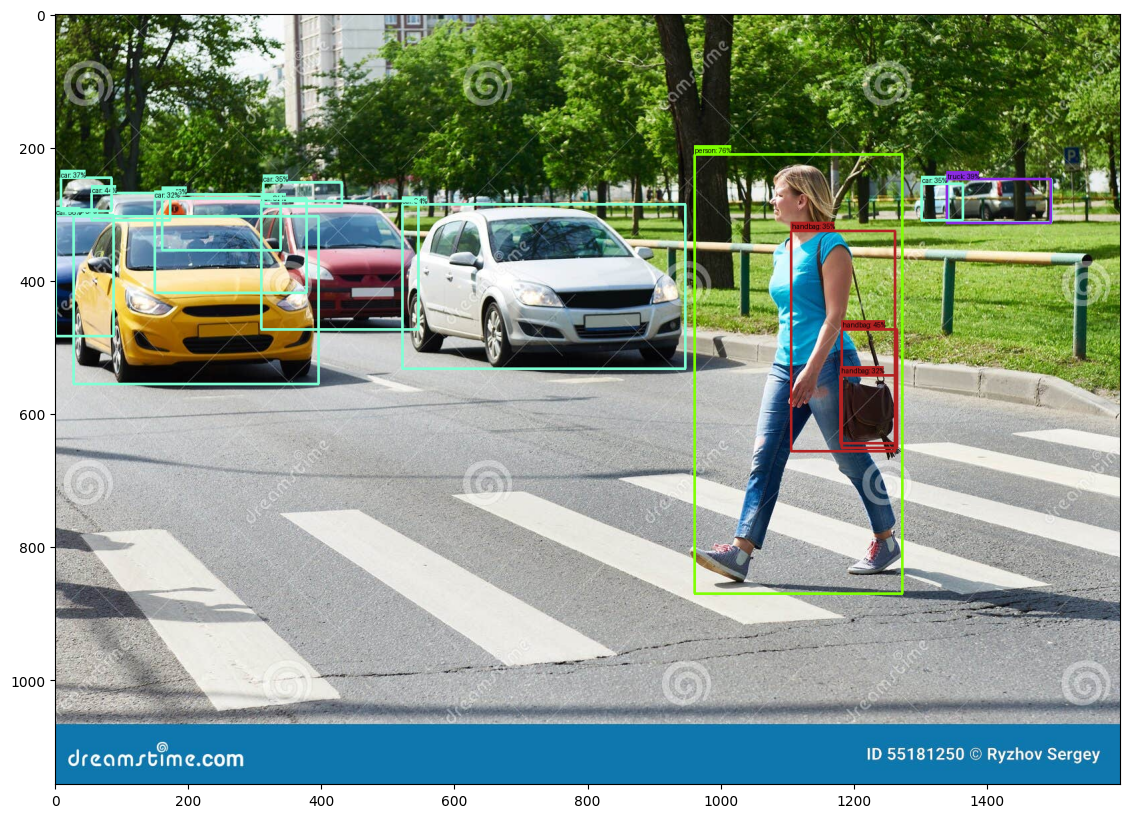

Done
Running inference for traffic.jpeg... Classes found:
truck
person
car
bus


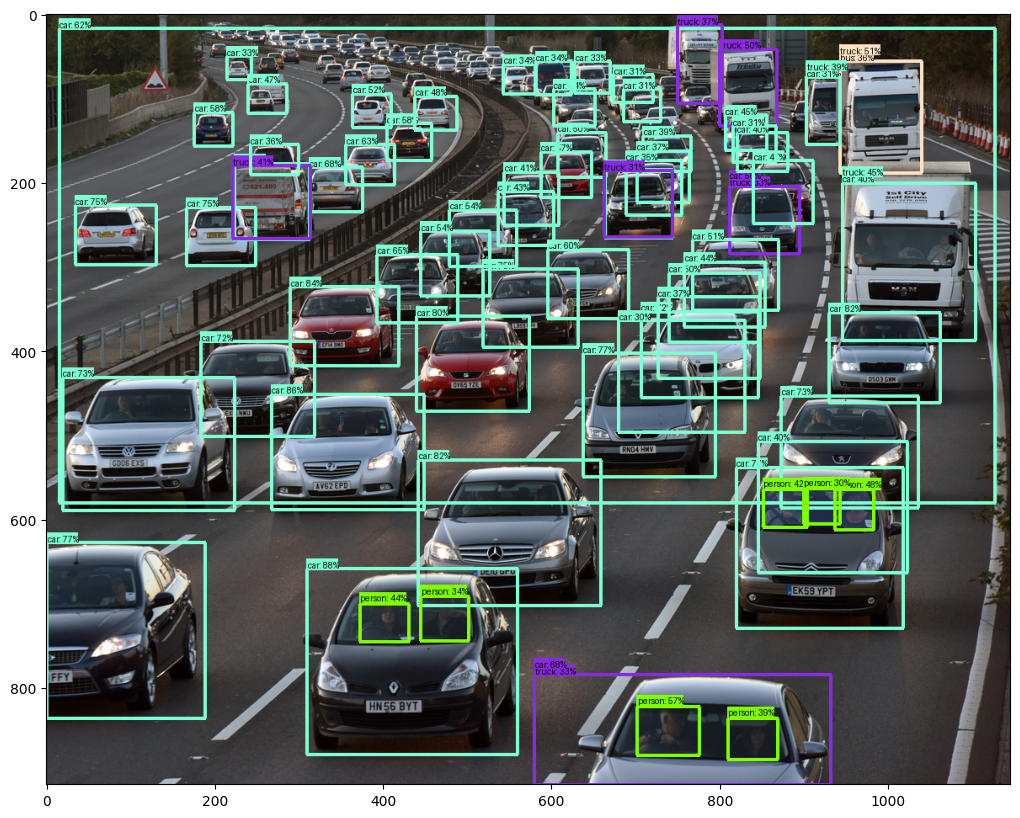

Done


In [9]:
# Run detection on images
for image_path in IMAGE_PATHS:
    detect_objects(image_path)